In [ ]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os
import warnings
warnings.filterwarnings("ignore")


class AudioAnalyzer:
    def __init__(self):
        self.audio_conf = {}
        self.windows = {'hamming': scipy.signal.hamming,
        'hann': scipy.signal.hann, 'blackman': scipy.signal.blackman,
           'bartlett': scipy.signal.bartlett}
    def preemphasis(self,signal,coeff=0.97):
        """perform preemphasis on the input signal.
        
        :param signal: The signal to filter.
        :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
        :returns: the filtered signal.
        """    
        return np.append(signal[0],signal[1:]-coeff*signal[:-1])
    
    def load_audio_DAVENet(self, file):
        audio_type = self.audio_conf.get('audio_type', 'melspectrogram')
        if audio_type not in ['melspectrogram', 'spectrogram']:
            raise ValueError('Invalid audio_type specified in audio_conf. Must be one of [melspectrogram, spectrogram]')
        preemph_coef = self.audio_conf.get('preemph_coef', 0.97)
        sample_rate = self.audio_conf.get('sample_rate', 16000)
        window_size = self.audio_conf.get('window_size', 0.025)
        window_stride = self.audio_conf.get('window_stride', 0.01)
        window_type = self.audio_conf.get('window_type', 'hamming')
        num_mel_bins = self.audio_conf.get('num_mel_bins', 40)
        target_length = self.audio_conf.get('target_length', 2048)
        use_raw_length = self.audio_conf.get('use_raw_length', False)
        padval = self.audio_conf.get('padval', 0)
        fmin = self.audio_conf.get('fmin', 20)
        n_fft = self.audio_conf.get('n_fft', int(sample_rate * window_size))
        win_length = int(sample_rate * window_size)
        hop_length = int(sample_rate * window_stride)
        print(f"STFT parameters:\n\tn_fft {n_fft}\n\twin_lenght {win_length}\n\thop_length {hop_length}")
        # load audio, subtract DC, preemphasis
        y, sr = librosa.load(file,sr=sample_rate)
        
        if y.size == 0:
            y = np.zeros(200)
        y = y - y.mean()
        y = self.preemphasis(y, preemph_coef)
        # compute mel spectrogram
        stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
            win_length=win_length,
            window=self.windows.get(window_type, self.windows['hamming']),
            center=True)
        spec = np.abs(stft)**2
        # if audio_type == 'melspectrogram':
        mel_basis = librosa.filters.mel(sr, n_fft, n_mels=num_mel_bins, fmin=fmin)
        melspec = np.dot(mel_basis, spec)
        logmelspec = librosa.power_to_db(melspec, ref=np.max)
        # elif audio_type == 'spectrogram':
        logspec = librosa.power_to_db(spec, ref=np.max)
        n_frames = logmelspec.shape[1]
        if use_raw_length:
            target_length = n_frames
        p = target_length - n_frames
        if p > 0:
            logmelspec = np.pad(logmelspec, ((0, 0), (0, p)), 'constant',
            constant_values=(-80, -80))
        elif p < 0:
            logmelspec = logmelspec[:, 0:p]
            n_frames = target_length
        # logspec = torch.FloatTensor(logspec)
        # return logspec, n_frames
        # return logspec.unsqueeze(0)
        return logspec,logmelspec, n_frames
    
def get_silence_ranges(y_db,sr=16000, threshold = -50, min_silence_length=0.5):
    # Find silent regions
    s_ranges = []
    start = None
    for i in range(len(y_db)):
        if y_db[i] < threshold:
            if start is None:
                start = i
        else:
            if start is not None:
                duration = (i - start) / sr
                if duration >= min_silence_length:
                    s_ranges.append((start / sr, i / sr))
                start = None
    if start is not None:
        duration = (i - start) / sr
        if duration >= min_silence_length:
            s_ranges.append((start / sr, len(y_db) / sr))
    return s_ranges

def get_silence_ranges_optimized(y_db, sr=16000, threshold=-50, min_silence_length=0.5):
    # Create a binary mask where True represents samples below threshold
    silence_mask = y_db < threshold
    
    # Find the indices where the mask changes (silence starts or ends)
    # We add padding to handle edge cases
    padded_mask = np.concatenate(([False], silence_mask, [False]))
    changes = np.where(padded_mask[1:] != padded_mask[:-1])[0]
        
    # Group these indices into pairs (start, end)
    starts = changes[0::2]
    ends = changes[1::2]
    
    # Filter out silence segments that are too short
    min_samples = int(min_silence_length * sr)
    long_enough = (ends - starts) >= min_samples
    
    # Convert sample indices to time in seconds
    starts_filtered = starts[long_enough] / sr
    ends_filtered = ends[long_enough] / sr
    
    return np.array(starts_filtered), np.array(ends_filtered)).T
    

audio_dir = "dir_exp_PlacesAudio/audio"
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]


In [2]:
import time
audio_path = os.path.join(audio_dir,"utterance_183783.wav")
y,sr = librosa.load(audio_path,sr=None)
tic = time.time()
yt, indices = librosa.effects.trim(y)
print(time.time()-tic)
print(indices)
print(type(y))

0.0032644271850585938
[     0 106255]
<class 'numpy.ndarray'>


In [3]:
import time
import random
idx = random.randint(0, len(audio_files) - 1)
audio_path = os.path.join(audio_dir, audio_files[idx])
# audio_path = os.path.join(audio_dir,"utterance_183783.wav")
print(f"audio {idx}th:", audio_files[idx])

y,sr = librosa.load(audio_path,sr=None)
print("nSamples", len(y))
print("sample rate",sr)
print("length in seconds", len(y)/sr)
peak = np.max(np.abs(y))
y_dbfs = 20*np.log10(np.abs(y)/ peak + 1e-10)

specmaker = AudioAnalyzer()

spec, melspec, nframes = specmaker.load_audio_DAVENet(audio_path)
print("nFrames", nframes)

threshold = -43
tic = time.time()
silence_ranges = get_silence_ranges(y_dbfs,threshold=threshold,min_silence_length=0.3)
print(f"my function {time.time()-tic}")
for i,r in enumerate(silence_ranges):
    print(f"range {i+1} start {r[0]} finish {r[1]}")


tic = time.time()
starts_silence, ends_silence = get_silence_ranges_optimized(y_dbfs,threshold=threshold,min_silence_length=0.3)
print(f"Claude's function {time.time() - tic}")
silent_ranges = np.array([starts_silence, ends_silence]).T
print(f"silent ranges shape {silent_ranges.shape}")
print(f"silent ranges {silent_ranges}")

print(f"\n-FREQUency domain-")
silent_f_ranges = np.round(silent_ranges/0.01)
print(f"silent ranges in frequency domain {silent_f_ranges}")

print(f"SIMILARITY Domain")
silent_s_ranges = np.round(silent_f_ranges/16)
print(f"silent ranges in similarity domain {silent_s_ranges}")
665/16



plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
for start, end in silence_ranges:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Silence')
plt.title('Waveform ')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



plt.subplot(4,1,2)
plt.plot(np.arange(len(y_dbfs)) / sr, y_dbfs, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('dBFS')
plt.xlabel('Time (s)')

plt.subplot(4,1,3)
im = plt.pcolormesh(np.arange(melspec.shape[1]), np.linspace(0, sr / 2, melspec.shape[0]), melspec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
for start, end in silent_f_ranges:
    plt.axvspan(start, end, color='green', alpha=0.3)
plt.title('Mel Spectrogram')
plt.xlabel('Time (nFrames)')
plt.ylabel('Frequency (Hz)')

plt.subplot(4,1,4)
im = plt.pcolormesh(np.arange(spec.shape[1]), np.linspace(0, sr / 2, spec.shape[0]), spec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
for start, end in silent_f_ranges:
    plt.axvspan(start, end, color='green', alpha=0.3)
plt.title('Spectrogram')
plt.xlabel('Time (nFrames)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()


ipd.Audio(audio_path)



audio 24th: utterance_97161.wav
nSamples 191147
sample rate 16000
length in seconds 11.9466875
STFT parameters:
	n_fft 400
	win_lenght 400
	hop_length 160
nFrames 1195
my function 0.872917652130127
range 1 start 0.1604375 finish 0.6765
range 2 start 4.9758125 finish 5.647625


TypeError: Cannot construct a dtype from an array

Output file saved to dir_exp_PlacesAudio/audio/silence_removedutterance_97161.wav
nSamples 191147
sample rate 16000
length in seconds 11.9466875
STFT parameters:
	n_fft 400
	win_lenght 400
	hop_length 160
nFrames 1195


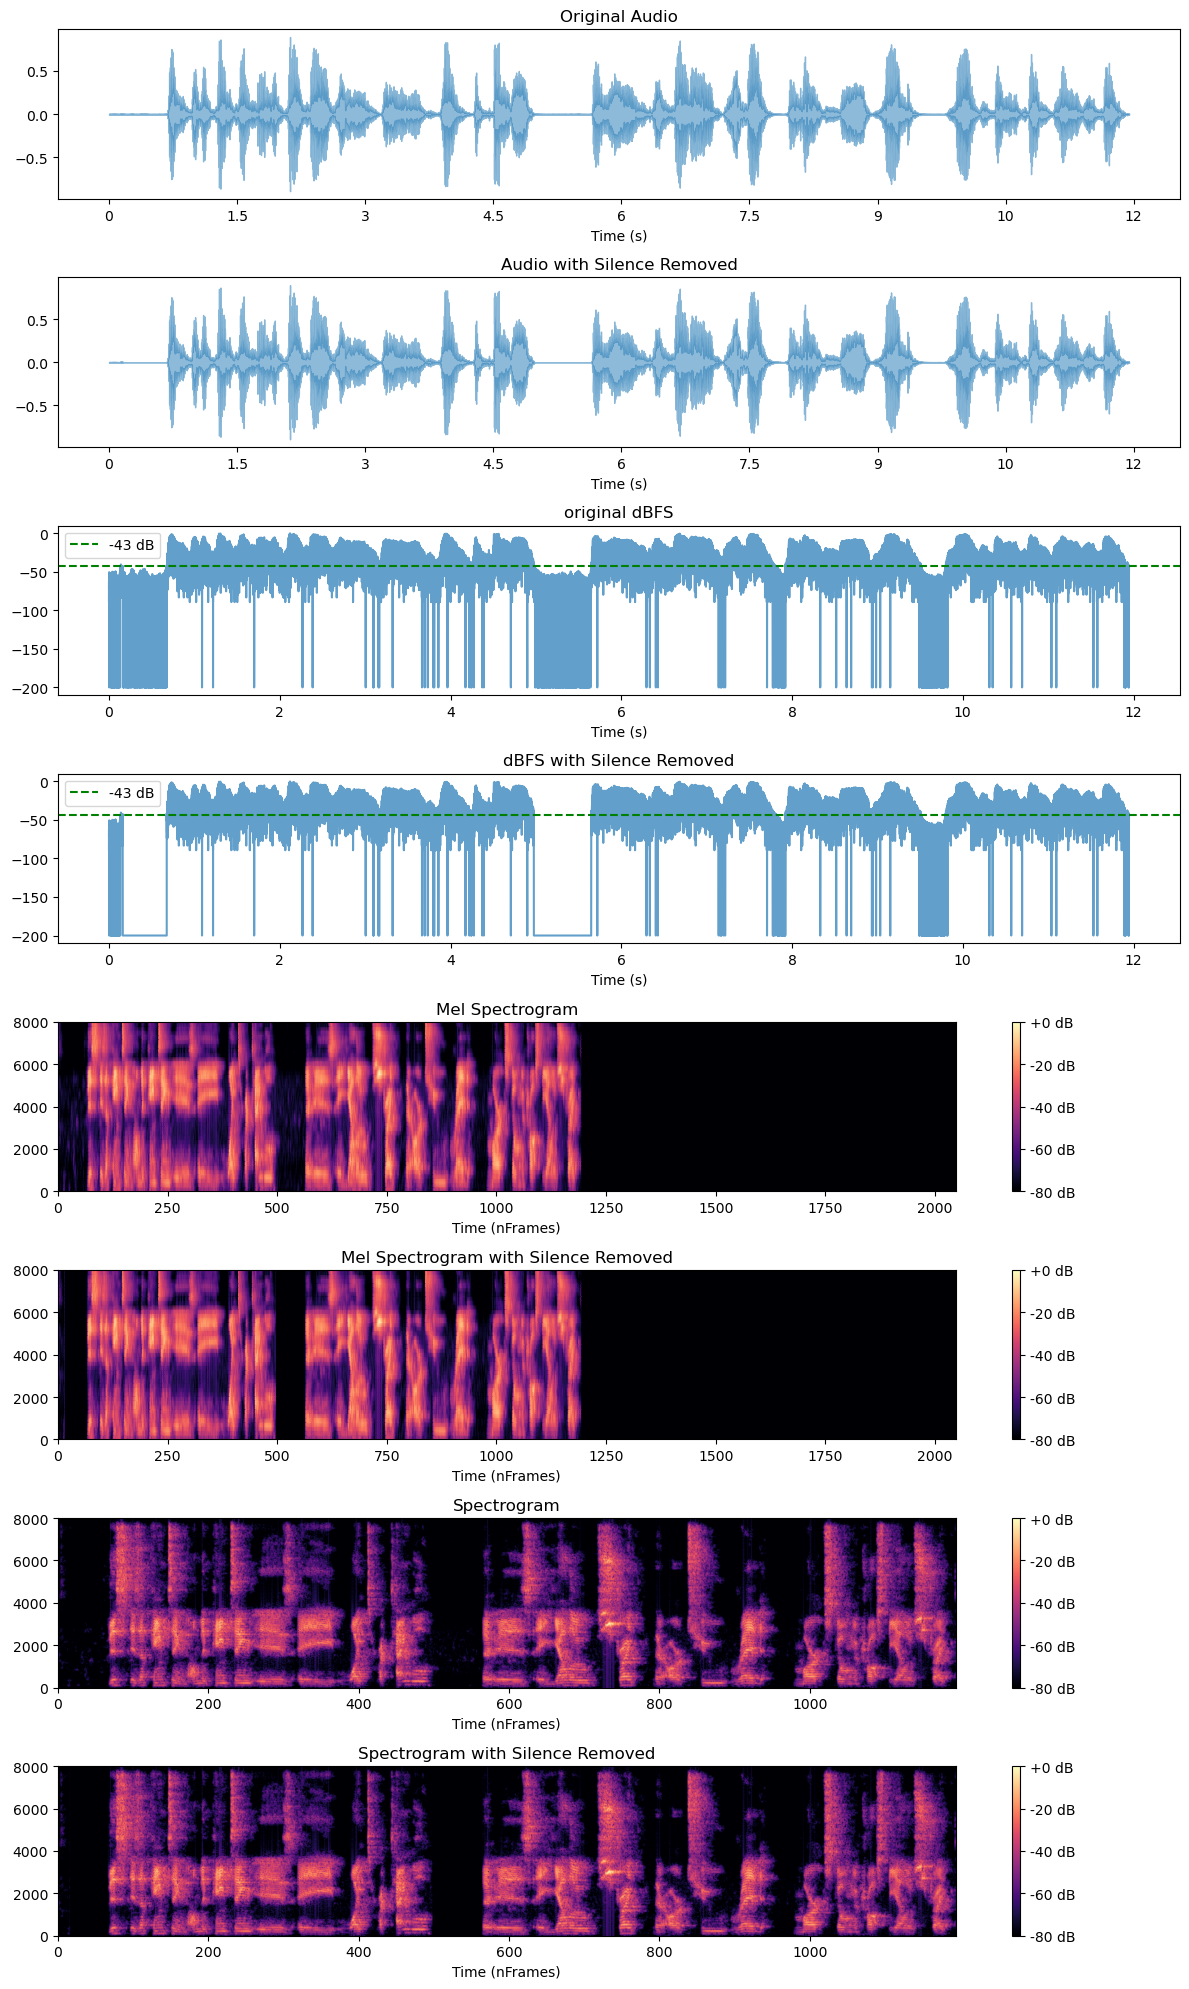

In [4]:
import soundfile as sf

# Set to zero the silent ranges and create a new audio file
y_silence = y.copy()
for start, end in silence_ranges:
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    y_silence[start_sample:end_sample] = 0
output_path = os.path.join(audio_dir, f"silence_removed{audio_files[idx]}")
sf.write(output_path, y_silence, sr, format='WAV')
print(f"Output file saved to {output_path}")
# Check the output
ipd.Audio(output_path)

# Check the output
y_silence, sr = librosa.load(output_path, sr=None)
print("nSamples", len(y_silence))
print("sample rate",sr)
print("length in seconds", len(y_silence)/sr)

plt.figure(figsize=(12, 20))
plt.subplot(8, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Original Audio')
plt.xlabel('Time (s)')
plt.subplot(8, 1, 2)
librosa.display.waveshow(y_silence, sr=sr, alpha=0.5)
plt.title('Audio with Silence Removed')
plt.xlabel('Time (s)')

peak = np.max(np.abs(y_silence))
y_silence_dbfs = 20*np.log10(np.abs(y_silence)/ peak + 1e-10)

plt.subplot(8, 1, 3)
plt.plot(np.arange(len(y_dbfs)) / sr, y_dbfs, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('original dBFS')
plt.xlabel('Time (s)')
plt.subplot(8, 1, 4)
plt.plot(np.arange(len(y_silence_dbfs)) / sr, y_silence_dbfs, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('dBFS with Silence Removed')
plt.xlabel('Time (s)')

plt.subplot(8, 1, 5)
im = plt.pcolormesh(np.arange(melspec.shape[1]), np.linspace(0, sr / 2, melspec.shape[0]), melspec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (nFrames)')
plt.subplot(8, 1, 6)

spec_silence, melspec_silence, nframes = specmaker.load_audio_DAVENet(output_path)
print("nFrames", nframes)
im = plt.pcolormesh(np.arange(melspec_silence.shape[1]), np.linspace(0, sr / 2, melspec_silence.shape[0]), melspec_silence, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Mel Spectrogram with Silence Removed')
plt.xlabel('Time (nFrames)')
plt.subplot(8, 1, 7)
im = plt.pcolormesh(np.arange(spec.shape[1]), np.linspace(0, sr / 2, spec.shape[0]), spec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (nFrames)')
plt.subplot(8, 1, 8)
im = plt.pcolormesh(np.arange(spec_silence.shape[1]), np.linspace(0, sr / 2, spec_silence.shape[0]), spec_silence, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Spectrogram with Silence Removed')
plt.xlabel('Time (nFrames)')
plt.tight_layout()




# Something

In [ ]:
import random
idx = random.randint(0, len(audio_files) - 1)
audio_path = os.path.join(audio_dir, audio_files[idx])
# audio_path = os.path.join(audio_dir,"utterance_183783.wav")
print(f"audio {idx}th:", audio_files[idx])

y,sr = librosa.load(audio_path,sr=None)
# Listen to the audio
peak = np.max(np.abs(y))
y_dbfs = 20*np.log10(np.abs(y)/ peak + 1e-10)
threshold = -43
get_silence_ranges(y_dbfs,threshold=threshold,min_silence_length=0.3)

audio 4th: utterance_262618.wav


[(4.763, 5.211375)]

In [ ]:


y_m = y - y.mean()
y_m = specmaker.preemphasis(y_m, 0.97)
peak = np.max(np.abs(y_m))
y_dbfs_m = 20*np.log10(np.abs(y_m)/ peak + 1e-10)
s_y_ranges_m = get_silence_ranges_optimized(y_dbfs_m,threshold=threshold,min_silence_length=0.3)




plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
for start, end in s_y_ranges:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Silence')
plt.title('Waveform ')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,2)
librosa.display.waveshow(y_m, sr=sr, alpha=0.5)
for start, end in s_y_ranges_m:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Silence')
plt.title('Waveform after preemphasis')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(4,1,3)
plt.plot(np.arange(len(y_dbfs)) / sr, y_dbfs, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('dBFS')
plt.xlabel('Time (s)')

plt.subplot(4,1,4)
plt.plot(np.arange(len(y_dbfs_m)) / sr, y_dbfs_m, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('dBFS after preemphasis')
plt.xlabel('Time (s)')
plt.tight_layout()

ipd.Audio(audio_path)


In [ ]:
# Listen to the audio y_m
ipd.Audio(y_m, rate=sr)

# Create the vectors

In [56]:
(2/24)

0.08333333333333333

In [37]:
def get_silence_ranges(y ,sr=16000, threshold = -50, min_silence_length=0.5):
    peak = np.max(np.abs(y))
    y_db = 20*np.log10(np.abs(y)/peak + 1e-10)

    # Find silent regions
    s_ranges = []
    start = None
    for i in range(len(y_db)):
        if y_db[i] < threshold:
            if start is None:
                start = i
        else:
            if start is not None:
                duration = (i - start) / sr
                if duration >= min_silence_length:
                    s_ranges.append((start / sr, i / sr))
                start = None
    if start is not None:
        duration = (i - start) / sr
        if duration >= min_silence_length:
            s_ranges.append((start / sr, len(y_db) / sr))
    return s_ranges

In [4]:
import os
audio_dir = "dir_exp_PlacesAudio/audio"
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

In [51]:
import random
import torch
import timeit
import librosa
import numpy as np
def get_silence_vector(y, sim_frames, sr=16000, threshold=-50, min_silence_length=0.5):
    """
        Harcoded to DAVEnet spectrograms and that there are 4 downsamplings in the audio encoder
        Therefore:
            - STFT frames: 2048 (window time shift of 0.01) 
            - Output T : 128 (scale by 1/16)
    """    
    
    peak = np.max(np.abs(y))
    y_db = 20*np.log10(np.abs(y)/peak + 1e-10)
    
    # Create a binary mask where True represents samples below threshold
    silence_mask = y_db < threshold
    
    # Find the indices where the mask changes (silence starts or ends)
    padded_mask = np.concatenate(([False], silence_mask, [False]))
    changes = np.where(padded_mask[1:] != padded_mask[:-1])[0]
    
    # Group these indices into pairs (start, end)
    starts = changes[0::2]
    ends = changes[1::2]
    
    # Filter out silence segments that are too short
    min_samples = int(min_silence_length * sr)
    long_enough = (ends - starts) >= min_samples
    
    # Convert sample indices to time in seconds
    starts_filtered = starts[long_enough] / sr
    ends_filtered = ends[long_enough] / sr
    
    
    # Create the binary silence vector
    silence_vector = np.zeros(128)
    
    # Mark regions with silence as 1
    if len(starts_filtered)> 0: 
        for start, end in zip(starts_filtered, ends_filtered):
            # Convert time to model indices
            start_idx = int(np.round(start / (0.01 * 16) ))
            end_idx = int(np.round(end / (0.01 * 16)))
            
            # Ensure indices are within bounds
            start_idx = max(0, min(start_idx, 128 - 1))
            end_idx = max(0, min(end_idx, 128 - 1))
            
            # Set the silence regions to 1
            silence_vector[start_idx:end_idx] = 1

    if sim_frames is not None:
        silence_vector[sim_frames:] = 1
        
    return torch.tensor(silence_vector.astype(int))

idx = random.randint(0, len(audio_files) - 1)
audio_path = os.path.join(audio_dir, audio_files[idx])
# audio_path = os.path.join(audio_dir,"utterance_183783.wav")
print(f"audio {idx}th:", audio_files[idx])

y, sr = librosa.load(audio_path)
nframes = np.round((len(y)/sr)/(0.01 * 16)).astype(int)
print(f"Audio is {(len(y)/sr)}s long and has {nframes} sim frames")
print(get_silence_ranges(y,threshold=-43, min_silence_length=0.3))




audio 27th: utterance_16862.wav
Audio is 22.698730158730157s long and has 142 sim frames
[(0.117875, 1.7705), (1.8368125, 3.46575), (7.3461875, 7.848875), (12.1141875, 12.920625), (19.33625, 19.9969375), (24.803875, 25.7496875), (29.2625, 31.152625)]


In [52]:
get_silence_vector(y,sim_frames=nframes,sr=sr,threshold=-43, min_silence_length=0.3)

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
timeit.timeit(lambda: get_silence_vector(y,sim_frames=nframes,sr=sr,threshold=-43, min_silence_length=0.3), number= 10000)


3.1629630429997633

In [ ]:
import random
import torch
import timeit
def get_silence_vector_pep(y_db, sr=16000, threshold=-50, min_silence_length=0.5, 
                       stft_hop=0.01, model_length=128):
    # Create a binary mask where True represents samples below threshold
    silence_mask = y_db < threshold
    
    # Find the indices where the mask changes (silence starts or ends)
    padded_mask = np.concatenate(([False], silence_mask, [False]))
    changes = np.where(padded_mask[1:] != padded_mask[:-1])[0]
    
    # Group these indices into pairs (start, end)
    starts = changes[0::2]
    ends = changes[1::2]
    
    # Filter out silence segments that are too short
    min_samples = int(min_silence_length * sr)
    long_enough = (ends - starts) >= min_samples
    
    # Convert sample indices to time in seconds
    starts_filtered = starts[long_enough] / sr
    ends_filtered = ends[long_enough] / sr
    
    # Convert time ranges to indices in the model's temporal dimension
    # First convert to frames based on stft_hop, then to model's resolution
    audio_length_seconds = len(y_db) / sr
    stft_frames = int(audio_length_seconds / stft_hop)
    scaling_factor = model_length / stft_frames
    
    # Create the binary silence vector
    silence_vector = np.zeros(model_length)
    
    # Mark regions with silence as 1
    for start, end in zip(starts_filtered, ends_filtered):
        # Convert time to model indices
        start_idx = int(np.round(start / stft_hop * scaling_factor))
        end_idx = int(np.round(end / stft_hop * scaling_factor))
        
        # Ensure indices are within bounds
        start_idx = max(0, min(start_idx, model_length-1))
        end_idx = max(0, min(end_idx, model_length))
        
        # Set the silence regions to 1
        silence_vector[start_idx:end_idx] = 1
        
    return torch.tensor(silence_vector.astype(int))

# Mega optimization
def get_silence_vector_torch(y_db, sr=16000, threshold=-50, min_silence_length=0.5, 
                            stft_hop=0.01, model_length=128):
    # Convert to torch tensor if not already
    if not isinstance(y_db, torch.Tensor):
        y_db = torch.tensor(y_db)
        
    # Find silent regions (using numpy for the change detection part)
    silence_mask = (y_db < threshold).cpu().numpy()
    padded_mask = np.concatenate(([False], silence_mask, [False]))
    changes = np.where(padded_mask[1:] != padded_mask[:-1])[0]
    
    # Group into start/end pairs
    starts = changes[0::2]
    ends = changes[1::2]
    
    # Filter out silence segments that are too short
    min_samples = int(min_silence_length * sr)
    long_enough = (ends - starts) >= min_samples
    
    # Convert sample indices to model indices
    audio_length_seconds = len(y_db) / sr
    stft_frames = int(audio_length_seconds / stft_hop)
    scaling_factor = model_length / stft_frames
    
    starts_filtered = torch.tensor(starts[long_enough] / sr / stft_hop * scaling_factor).long()
    ends_filtered = torch.ceil(torch.tensor(ends[long_enough] / sr / stft_hop * scaling_factor)).long()
    
    # Clip indices to ensure they're within bounds
    starts_filtered = torch.clamp(starts_filtered, 0, model_length-1)
    ends_filtered = torch.clamp(ends_filtered, 0, model_length)
    
    # Create the silence vector (all zeros)
    silence_vector = torch.zeros(model_length, dtype=torch.int)
    
    if len(starts_filtered) > 0:
        # Create a position tensor for broadcasting
        positions = torch.arange(model_length)
        
        # Check if each position is in any silence range
        # This creates a 2D boolean tensor of shape (num_ranges, model_length)
        in_range = (positions >= starts_filtered[:, None]) & (positions < ends_filtered[:, None])
        
        # If a position is in any range, mark it as silence
        silence_vector = torch.any(in_range, axis=0).int()
    
    return silence_vector

def get_silence_vector_vectorized(y_db, sr=16000, threshold=-50, min_silence_length=0.5, 
                                 stft_hop=0.01, model_length=128):
    # Create a binary mask where True represents samples below threshold
    silence_mask = y_db < threshold
    
    # Find the indices where the mask changes (silence starts or ends)
    padded_mask = np.concatenate(([False], silence_mask, [False]))
    changes = np.where(padded_mask[1:] != padded_mask[:-1])[0]
    
    # Group these indices into pairs (start, end)
    starts = changes[0::2]
    ends = changes[1::2]
    
    # Filter out silence segments that are too short
    min_samples = int(min_silence_length * sr)
    long_enough = (ends - starts) >= min_samples
    
    # Convert sample indices to time in seconds
    starts_filtered = starts[long_enough] / sr
    ends_filtered = ends[long_enough] / sr
    
    # Convert time ranges to indices in the model's temporal dimension
    audio_length_seconds = len(y_db) / sr
    stft_frames = int(audio_length_seconds / stft_hop)
    scaling_factor = model_length / stft_frames
    
    # Create indices in the model's temporal space
    start_indices = (starts_filtered / stft_hop * scaling_factor).astype(int)
    end_indices = np.ceil(ends_filtered / stft_hop * scaling_factor).astype(int)
    
    # Clip indices to ensure they're within bounds
    start_indices = np.clip(start_indices, 0, model_length-1)
    end_indices = np.clip(end_indices, 0, model_length)
    
    # Create the silence vector using vectorized operations
    model_positions = np.arange(model_length)
    silence_vector = np.zeros(model_length, dtype=int)
    
    # For each position, check if it falls within any silence range
    # This uses broadcasting to compare each position against all ranges at once
    if len(start_indices) > 0:
        # For each model position, check if it's >= any start AND < any end
        # This creates a 2D boolean array of shape (num_ranges, model_length)
        in_range = (model_positions >= start_indices[:, None]) & (model_positions < end_indices[:, None])
        # If a position is in any range, mark it as silence (logical OR across ranges)
        silence_vector = np.any(in_range, axis=0).astype(int)
    
    return torch.tensor(silence_vector)

idx = random.randint(0, len(audio_files) - 1)
audio_path = os.path.join(audio_dir, audio_files[idx])
# audio_path = os.path.join(audio_dir,"utterance_183783.wav")
print(f"audio {idx}th:", audio_files[idx])


y, sr = librosa.load(audio_path, sr=None)
print(f"audio duration {len(y)/sr} seconds")
y_dbfs = 20 * np.log10(np.abs(y) / peak + 1e-10)
print(get_silence_ranges(y_dbfs, threshold=threshold, min_silence_length=0.3))
silence_ranges = timeit.timeit(lambda: get_silence_vector(y_dbfs, threshold=threshold, min_silence_length=0.3), number=1000)
print(f"Execution time: {silence_ranges} seconds")
# Using the optimized function

sil = timeit.timeit(lambda: get_silence_vector_torch(y_dbfs, threshold=threshold, min_silence_length=0.3), number=1000)
print(f"Execution time: {sil} seconds")

silc = timeit.timeit(lambda: get_silence_vector_vectorized(y_dbfs, threshold=threshold, min_silence_length=0.3), number=1000)
print(f"Execution time: {silc} seconds")

out1 = get_silence_vector(y_dbfs, threshold=threshold, min_silence_length=0.3)
out2 = get_silence_vector_torch(y_dbfs, threshold=threshold, min_silence_length=0.3)
out3 = get_silence_vector_vectorized(y_dbfs, threshold=threshold, min_silence_length=0.3)

print(f"out1 {out1} {out1.shape}")
print(f"out2 {out2} {out2.shape}")
print(f"out3 {out3} {out3.shape}")



# v_silence = np.arange(0, 128)
# v_silence =  silent_s_ranges[:,1] > v_silence >= silent_s_ranges[:, 0] 



NameError: name 'audio_files' is not defined